In [3]:
push!(LOAD_PATH, pwd()*"/..")
using LightGraphs, Epidemics, GraphGeneration,IM
using GraphGeneration
using NLsolve
using PyPlot, Distributions

In [4]:
function get_k_range(N)
    return collect(1:N-1)
end

function get_mean_k(p_k_fn::Function,N::Int)
    mean_k = 0
    k_range = get_k_range(N)
    for k in k_range
        mean_k += k*p_k_fn(k) 
    end
    return mean_k
end

function get_mean_k(p_k::Array,N::Int)
    return dot(p_k,get_k_range(N))
end

function neighbor_degree_distribution(k,degree_distribution,mean_k)
    return k * degree_distribution(k)/mean_k
end




function get_mean_y_k(y_k,p_k_neighbor,N)
    k_range = get_k_range(N)
    mean_y_k = 0
    for k in k_range
        mean_y_k += y_k[k]*p_k_neighbor[k]
    end
    return mean_y_k
end

function get_mean_y_k_squared(mean_y_k,k)
    return mean_y_k^2 + (1 - mean_y_k)* mean_y_k/k
end


function y_k_dot_given_y_k!(y_k,y_k_dot,y_desired,N,p_k,p_k_neighbor,alpha,beta)
    k_range = get_k_range(N)
    mean_y_k = get_mean_y_k(y_k,p_k_neighbor,N)
    for k in k_range
        mean_y_k_squared = get_mean_y_k_squared(mean_y_k,k)
        y_k_dot[k] = y_k[end]*get_delta_y_k_plus(y_k,k,mean_y_k,mean_y_k_squared,alpha) - get_delta_y_k_minus(y_k,k,mean_y_k,beta) 
    end
    y_k_dot[end] = y_desired - get_y_bar(p_k,y_k) 
end

function get_delta_y_k_plus(y_k,k,mean_y_k,mean_y_k_squared,alpha)
    return (1 - y_k[k])*(mean_y_k + alpha*mean_y_k_squared)
end

function get_delta_y_k_minus(y_k,k,mean_y_k,beta)
    return y_k[k]* (1 - mean_y_k)*(1 + beta)
end

function get_delta_y_plus(y_k,p_k,mean_y_k,N,alpha)
    k_range = get_k_range(N)
    ret = 0
    for k in k_range
        mean_y_k_squared = get_mean_y_k_squared(mean_y_k,k)
        ret += get_delta_y_k_plus(y_k,k,mean_y_k,mean_y_k_squared,alpha)*p_k[k]
    end
    return ret
end

function get_delta_y_minus(y_k,p_k,mean_y_k,N,beta)
    k_range = get_k_range(N)
    ret = 0
    for k in k_range
        ret += get_delta_y_k_minus(y_k,k,mean_y_k,beta)*p_k[k]
    end
    return ret
end
 
function get_y_bar(p_k,y_k)
    return dot(p_k,y_k[1:end-1])
end
    

function mock_degree_distribution(mean_k,sigma_k)
    function p_k(k)
        if k == mean_k + sigma_k
            return 0.5
        elseif k == mean_k - sigma_k
            return 0.5
        else
            return 0
        end
    end
    return p_k
end

function get_y_k_equilibrium(y_desired,N,p_k,p_k_neighbor,alpha,beta)
    f!(x,out) = y_k_dot_given_y_k!(x,out,y_desired,N,p_k,p_k_neighbor,alpha,beta)
    x_init = 1/N*zeros(N)
    ret = nlsolve(f!,x_init,autodiff=true,ftol=1e-12)
    y_k = ret.zero
    return y_k
end



function get_y_k_branching_process(y_desired,p_k,alpha,N)
    y_k = ones(N)
    for k = 1:N-1
        y_k[k] = (1 + alpha/k)
    end
    return y_desired*y_k/dot(y_k[1:N-1],p_k)
end

get_y_k_branching_process (generic function with 1 method)

In [5]:
c_r = 0.2
N = 2000
y_n = 0.2

n_n = Int(N*y_n)#y_n*N
beta = 4.0/(c_r*n_n)
alpha = (N*beta)/n_n

k = 10
sigma_k = 20
min_degree = 3

k_range = get_k_range(N) 

# degr_distr = mock_degree_distribution(k,sigma_k)

degr_distr = get_p_k_gamma(sigma_k,k,min_degree)
degree_distribution(x) = degr_distr(x) #(x) = 1/N
mean_k = get_mean_k(degree_distribution,N)
neighbor_degree_distribution(x) = neighbor_degree_distribution(x,degree_distribution,mean_k)
p_k = []
p_k_neighbor = []
for x in k_range
    push!(p_k,degree_distribution(x))
    push!(p_k_neighbor,neighbor_degree_distribution(x))
end
p_k /= sum(p_k)
p_k_neighbor /= sum(p_k_neighbor)
mean_k

11.372421864768082

In [6]:
y_desired_range = logspace(log10(1/N),log10(1),100) 
delta_y_plus = similar(y_desired_range)
delta_y_minus = similar(y_desired_range)
y_bar = similar(y_desired_range)
gammas = similar(y_desired_range)
y_local = similar(y_desired_range)
for (i,y_desired) in enumerate(y_desired_range)
    println(i)
#     if i == 1
#         y_k = y_desired*ones(N)
#     else
#       y_k = y_desired*ones(N)
      y_k = get_y_k_equilibrium(y_desired,N,p_k,p_k_neighbor,alpha,beta)
#     y_k = get_y_k_branching_process(y_desired,p_k,alpha,N)#get_y_k_equilibrium(y_desired,N,p_k,p_k_neighbor,alpha,beta)
#     end
#     y_k /= 2.0
    mean_y_k = get_mean_y_k(y_k,p_k_neighbor,N)
    
    y_local[i] = mean_y_k
    gammas[i] = y_k[end]
    y_bar[i] = get_y_bar(p_k,y_k) 
    delta_y_plus[i] = get_delta_y_plus(y_k,p_k,mean_y_k,N,alpha)
    delta_y_minus[i] = get_delta_y_minus(y_k,p_k,mean_y_k,N,beta)
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


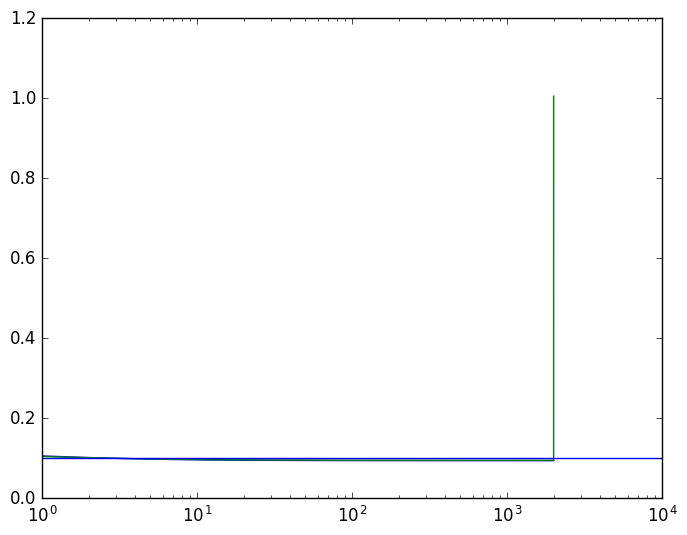

PyObject <matplotlib.lines.Line2D object at 0x3236c3e50>

In [7]:
y_desired_curr = 0.1
semilogx(get_y_k_branching_process(y_desired_curr,p_k,alpha,N))
semilogx(get_y_k_equilibrium(y_desired_curr,N,p_k,p_k_neighbor,alpha,beta))
# semilogx(y_desired_range,y_k)
axhline(0.1)

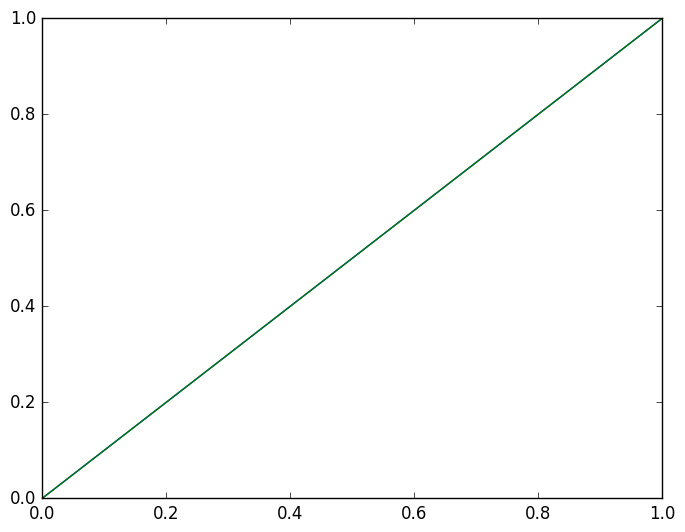

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32f376910>

In [8]:
plot(y_desired_range,y_local)
plot(y_desired_range,y_bar)

In [9]:
s = delta_y_plus - delta_y_minus
splus = delta_y_plus + delta_y_minus
# plot(y_desired_range,s./(y_desired_range.*(1 - y_desired_range)))
# # plot(y_desired_range,s1./(y_desired_range.*(1 - y_desired_range)))
# plot(y_desired_range,alpha*y_desired_range - beta)
# plot(y_desired_range,get_s_eff_exact(y_desired_range,alpha,beta,k,N))
# # plot(y_desired_range,get_s_eff_degree_distribution_gamma(y_desired_range,alpha,beta,k,sigma_k,N))
# plot(y_desired_range,get_s_eff_degree_distribution(y_desired_range,alpha,beta,degree_distribution,N))

100-element Array{Float64,1}:
 0.00105391 
 0.00113797 
 0.00122873 
 0.00132673 
 0.00143254 
 0.00154678 
 0.00167013 
 0.0018033  
 0.00194709 
 0.00210233 
 0.00226993 
 0.00245088 
 0.00264624 
 ⋮          
 0.536927   
 0.546538   
 0.551146   
 0.54933    
 0.539366   
 0.519172   
 0.486236   
 0.437529   
 0.369402   
 0.277468   
 0.156449   
 1.51545e-15

In [10]:
using Dierckx
interpolation_order = 3
s_fn(x) = evaluate(Spline1D(y_desired_range,s,k=interpolation_order,bc="extrapolate"),x)
splus_fn(x) = evaluate(Spline1D(y_desired_range,splus,k=interpolation_order,bc="extrapolate"),x)


splus_fn (generic function with 1 method)

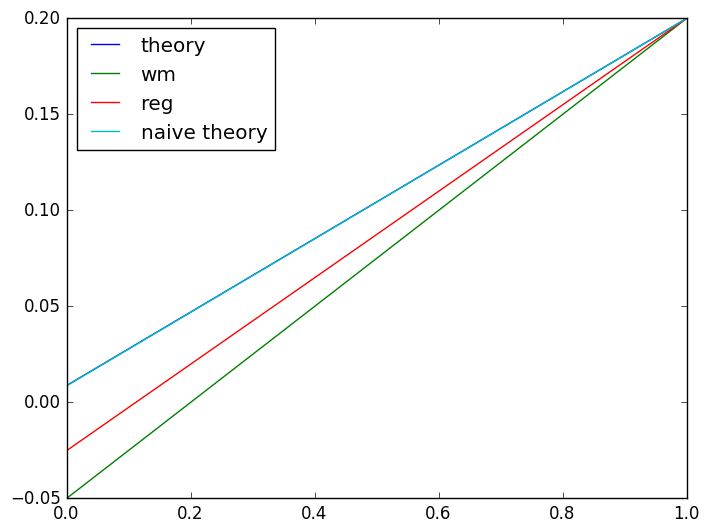

PyObject <matplotlib.legend.Legend object at 0x30b69e150>

In [13]:

plot(yy,s_fn(yy)./(yy.*(1 - yy)),label="theory")
# plot(y_desired_range,s./(y_desired_range.*(1 - y_desired_range)),"o")
plot(yy,alpha*yy - beta,label="wm")
plot(yy,get_s_eff_exact(yy,alpha,beta,k,N),label="reg")
plot(yy,get_s_eff_degree_distribution(yy,alpha,beta,degree_distribution,N),label="naive theory")
legend(loc="best")

In [12]:
dx = 1/N
yy = collect(1/N:dx:1)
pp = P_reach_fast(s_fn,splus_fn,N,1.0/N,yy)
im = InfectionModel(x -> 1 + beta + get_s_eff_exact(x,alpha,beta,k,N) , x -> 1 + beta);
pp_regular = P_reach_fast(im,N,1.0/N,yy,true)
im = InfectionModel(x -> 1 + beta + get_s_eff_degree_distribution_gamma(x,alpha,beta,k,sigma_k,N) , x -> 1 + beta);
pp_naive = P_reach_fast(im,N,1.0/N,yy,true)



2000-element Array{Float64,1}:
 1.0      
 0.502069 
 0.336109 
 0.253139 
 0.203366 
 0.170191 
 0.146501 
 0.128738 
 0.114928 
 0.103884 
 0.0948519
 0.0873287
 0.0809663
 ⋮        
 0.013341 
 0.013341 
 0.013341 
 0.013341 
 0.013341 
 0.013341 
 0.013341 
 0.013341 
 0.013341 
 0.013341 
 0.013341 
 0.013341 

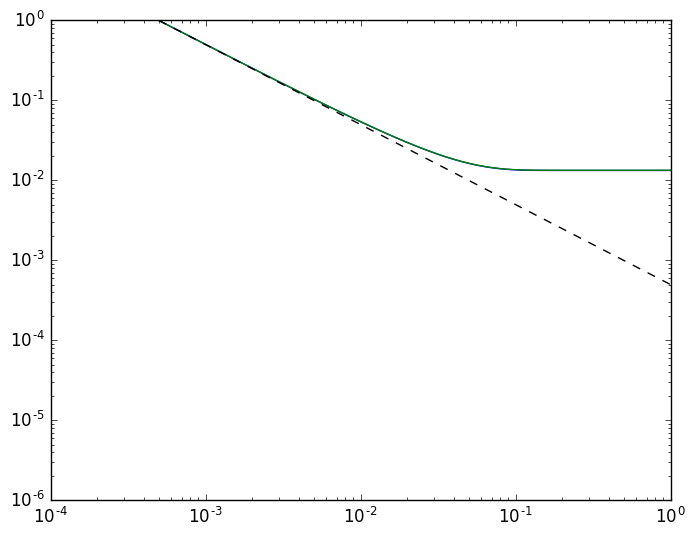

(1.0e-6,1.0)

In [18]:
# loglog(yy,pp_regular)
loglog(yy,pp_naive)
# loglog(yy,pp_test)
loglog(yy,pp)
# plot(yy,pp1,label="intermediate")
# plot(yy,pp2,label="equal y_k")
# plot(yy,pp3,label="newest")
# plot(yy,pp4,label="newest")
plot(yy,1./(N*yy),"--k")
legend()
# plot(yy,log(N*yy))
# xlim([0,0.01])
ylim([1e-6,1e0])

In [8]:
function get_s(k_tilde,k_bar,y_0)
    y_tilde = y_0*k_tilde/k_bar 
    a = (1 - y_0)*y_tilde - (1 - y_tilde)*y_0*(1 + beta)
    b = 1/N*((1 - y_0)*y_tilde + (1 - y_tilde)*y_0*(1 + beta))
    s = 2*a/(N*b)
end

function get_a(k_tilde,k_bar,y_0)
    y_tilde = y_0*k_tilde/k_bar 
    a = (1 - y_0)*y_tilde - (1 - y_tilde)*y_0*(1 + beta)
    return a
end
    
function get_b(k_tilde,k_bar,y_0)
    y_tilde = y_0*k_tilde/k_bar 
    b = 1/N*((1 - y_0)*y_tilde + (1 - y_tilde)*y_0*(1 + beta))
    return b
end

get_b (generic function with 1 method)

In [32]:
function sample_n_k_distribution(n,N,p_k,y_k)
    ks = collect(1:N-1)
    samp = zeros(ks)
    d = Multinomial(N,p_k)
    N_k = rand(d)
    for i = 1:n
        weight_vec = 1/N*N_k.*y_k
        k_curr = sample(ks,WeightVec(weight_vec))
        N_k[k_curr] -= 1
        samp[k_curr] += 1
    end
    samp
end

sample_n_k_distribution (generic function with 1 method)

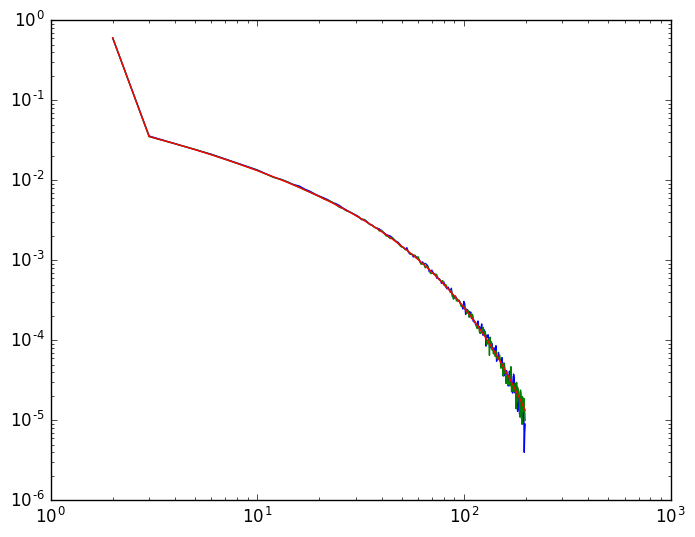

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x334808090>

In [256]:
n = 100
arr = 1.0*zeros(N-1)
arr1 = 1.0*zeros(N-1)
y_k = get_y_k_equilibrium(n/N,N,p_k,p_k_neighbor,alpha,beta)[1:end-1]
y_k /= sum(y_k)
d = Multinomial(n,y_k.*p_k/sum(y_k.*p_k))
num_samples = 10000
for i = 1:num_samples
    arr += sample_n_k_distribution(n,N,p_k,y_k)
    arr1 += rand(d)
end
loglog(arr/sum(arr))
loglog(arr1/sum(arr1))
plot(p_k.*y_k./sum(p_k.*y_k))

In [40]:
using Distributions 
using StatsBase
function get_s_mc(n,N,k_bar,p_k,y_k,alpha,beta,num_samples = 100;replacement=true)
    z_k = p_k .* y_k
    z_k /= sum(z_k)
    y_k /= sum(y_k)
    y = n/N
    d = Multinomial(n,z_k)
    k_vec = collect(1:N-1)
    a_accum = 0
    b_accum = 0
    s_accum = 0
    for i = 1:num_samples
        if replacement
            n_k_sample = rand(d)
        else
            n_k_sample = sample_n_k_distribution(n,N,p_k,y_k)
        end
#         println(n_k_sample)
        y_tilde_vec = dot(k_vec,n_k_sample)/(N*k_bar) * ones(Float64,k_vec)
        y_tilde_sq_vec = y_tilde_vec.*(y_tilde_vec + (1 - y_tilde_vec).*(N - k_vec)./(N*k_vec))
#         println(y_tilde_sq_vec)
        a_curr = dot(p_k,get_a_y_y_tilde(y,y_tilde_vec,y_tilde_sq_vec,alpha,beta) )
        b_curr = dot(p_k,get_b_y_y_tilde(y,y_tilde_vec,y_tilde_sq_vec,alpha,beta,N) )
        s_curr = get_s_from_a_b(a_curr,b_curr,N)
        a_accum += a_curr
        b_accum += b_curr
        s_accum += s_curr
    end
    a_accum /= num_samples
    b_accum /= num_samples
    s_accum /= num_samples
    
    s_pre_ave = s_accum
    s_post_ave = get_s_from_a_b(a_accum,b_accum,N)
    
    return s_pre_ave, s_post_ave, a_accum, b_accum
end
    
function get_s_from_a_b(a,b,N)
    return 2*a/(N*b)
end

function get_a_y_y_tilde(y,y_tilde,beta)
    return (1 - y)*y_tilde - (1 - y_tilde)*y*(1 + beta)
end
    
function get_b_y_y_tilde(y,y_tilde,beta,N)
    return 1/N*((1 - y)*y_tilde + (1 - y_tilde)*y*(1 + beta))
end

function get_a_y_y_tilde(y,y_t,y_t_sq,alpha,beta)
    return (1 - y)*(y_t + alpha*y_t_sq) - (1 - y_t)*y*(1 + beta)
end
    
function get_b_y_y_tilde(y,y_t,y_t_sq,alpha,beta,N)
    return 1/N*((1 - y)*(y_t + alpha*y_t_sq) + (1 - y_t)*y*(1 + beta))
end

function get_integer_logspace(x0,x1,num)
    raw = logspace(log10(x0),log10(x1),num)
    raw = [Int(round(_)) for _ in raw]
    for i = 2:length(raw)
        raw[i] = max(raw[i],raw[i-1]+1)
    end
    return raw
end
    

get_integer_logspace (generic function with 1 method)

In [41]:
c_r = 0.2
N = 2000
y_n = 0.2

n_n = Int(N*y_n)#y_n*N
beta = 4.0/(c_r*n_n)
alpha = (N*beta)/n_n

k = 10
sigma_k = 20
min_degree = 3

k_range = get_k_range(N) 

# degr_distr = mock_degree_distribution(k,sigma_k)

degr_distr = get_p_k_gamma(sigma_k,k,min_degree)
degree_distribution(x) = degr_distr(x) #(x) = 1/N
mean_k = get_mean_k(degree_distribution,N)
neighbor_degree_distribution(x) = neighbor_degree_distribution(x,degree_distribution,mean_k)
p_k = []
p_k_neighbor = []
for x in k_range
    push!(p_k,degree_distribution(x))
    push!(p_k_neighbor,neighbor_degree_distribution(x))
end
p_k /= sum(p_k)
p_k_neighbor /= sum(p_k_neighbor)
mean_k

11.372421864768082

In [42]:
n_range = get_integer_logspace(1,0.95*N,50)
# get_s_mc(15,N,mean_k,p_k,z_k,alpha,beta,1)

50-element Array{Int64,1}:
    1
    2
    3
    4
    5
    6
    7
    8
    9
   10
   11
   12
   13
    ⋮
  349
  407
  475
  554
  646
  754
  879
 1026
 1197
 1396
 1629
 1900

In [43]:
#should be p_k * y_k
z_k = 1.0*p_k
z_k = z_k ./ sum(z_k)
# n_range = collect(1:N)
# n_range = vcat(collect(1:9),collect(10:10:99),collect(100:100:N))
y_range = n_range/N
s_range = zeros(Float64,n_range)
a_range = zeros(Float64,n_range)
b_range = zeros(Float64,n_range)
replacement = false
num_samples = 500
upper_lim = 3000
lower_lim = 2000

for i in 1:length(n_range)
    n = n_range[i]
    print(n," ")
    y_k = get_y_k_equilibrium(n/N,N,p_k,p_k_neighbor,alpha,beta)[1:end-1]
#     y_k = n/N*ones(N-1)
#     y_k /= sum(y_k)
#     if n < lower_lim 
#         s_range[i],_,a_range[i],b_range[i] = get_s_mc(n,N,mean_k,p_k,y_k,alpha,beta,num_samples,replacement=replacement)
#     else
    s_range[i],_,a_range[i],b_range[i] = get_s_mc(n,N,mean_k,p_k,y_k,alpha,beta,num_samples,replacement=replacement)
#     end
end
    

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 22 25 30 35 40 47 55 64 75 87 102 119 138 161 188 220 256 299 349 407 475 554 646 754 879 1026 1197 1396 1629 1900 

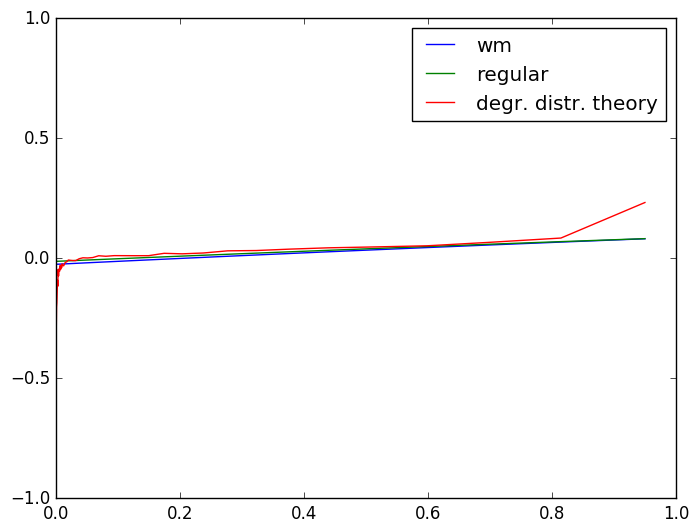

(-1,1)

In [44]:
using Dierckx
interpolation_order = 1
spl = Spline1D(n_range/N,s_range,k=interpolation_order,bc="extrapolate")
s_fn(x) = evaluate(spl,x)
# a_fn(x) = evaluate(Spline1D(n_range/N,a_range,k=interpolation_order,bc="extrapolate"),x)
# b_fn(x) = evaluate(Spline1D(n_range/N,N*b_range,k=interpolation_order,bc="extrapolate"),x)
# plot(y_range,alpha*y_range-beta,label="wm")
plot(y_range,(alpha*y_range-beta)./(2 + alpha*y_range + beta),label="wm")
plot(y_range,get_s_eff_exact(y_range,alpha,beta,k,N)./(2 +get_s_eff_exact(y_range,alpha,beta,k,N) + 2*beta) ,label="regular")
plot(y_range,s_fn(y_range)/2,label="degr. distr. theory")
# plot(y_range,s_fn1(y_range)/2,label="theory")
# plot(y_range,s_range,alpha=0.2)
legend(loc="best")
ylim(-1,1)

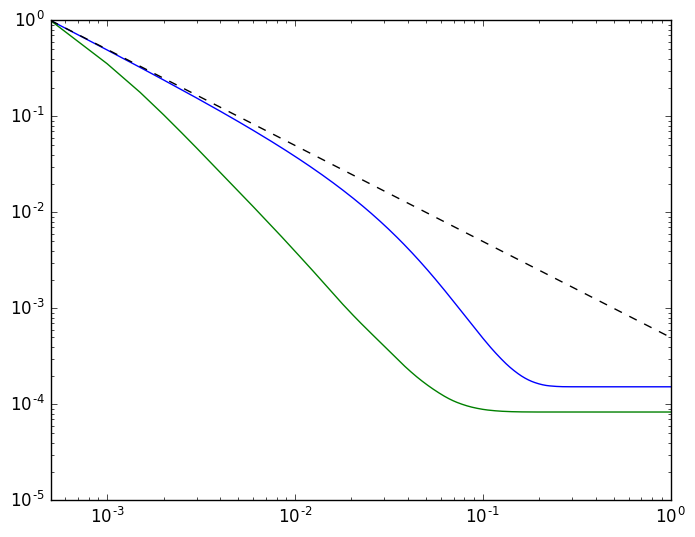

(0.0005,1.0)

In [46]:
yy = collect(1/N:1/N:1)        
im_reg = InfectionModel(x -> 1 + beta + get_s_eff_exact(x,alpha,beta,mean_k,N) , x -> 1 + beta);
im_wm = InfectionModel(x -> 1 + alpha*x, x -> 1 + beta);
pp_wm = P_reach_fast(im_wm,N,1.0/N,yy,true)
pp_reg = P_reach_fast(im_reg,N,1.0/N,yy,true)
pp_test = P_reach_raw_fast(x -> N*s_fn(x)/2,N,1.0/N,yy)
# pp_test = P_reach_raw_fast(x -> N*get_s_eff_exact(x,alpha,beta,mean_k,N)/(2 + get_s_eff_exact(x,alpha,beta,mean_k,N)+2*beta),N,1.0/N,yy)
# pp_test = P_reach_raw_fast(x -> N*(alpha*x - beta)/(2 +alpha*x+beta),N,1.0/N,yy)
# pp_test = P_reach_raw_fast(a_fn,x -> 1/N*b_fn(x),N,1.0/N,yy)

# loglog(yy,pp_wm)
loglog(yy,pp_reg)
loglog(yy,pp_test)
loglog(yy,1./(N*yy),"--k")
ylim([1e-5,1])
xlim([1/N,1])

In [104]:

s_pre,s_post = get_s_mc(1,N,mean_k,z_k,beta,1000)

(-0.6164279674464951,0.013101371764774076)

In [59]:
beta = 0.01
y_0 = 1/N
a_vec =  [get_a(_,mean_k,y_0) for _ in 1:N-1]
b_vec =  [get_b(_,mean_k,y_0) for _ in 1:N-1]
a_mean = dot(a_vec,z_k)
b_mean = dot(b_vec,z_k)

2*a_mean/(N*b_mean)

-0.00994811852969141

1.0

In [56]:
beta = 0.01
y_0 = 1/N
s_k_tilde_vec = [get_s(_,mean_k,y_0) for _ in 1:N-1]
s_mean = dot(s_k_tilde_vec,z_k)
s_ideal = -beta
s_mean, s_ideal

(-0.6015593853177895,-0.01)

In [58]:
s_k_tilde_vec

399-element Array{Float64,1}:
 -1.68029  
 -1.4078   
 -1.17278  
 -0.968    
 -0.787977 
 -0.628478 
 -0.486182 
 -0.358448 
 -0.24315  
 -0.138555 
 -0.0432403
  0.0439776
  0.124088 
  ⋮        
  1.89429  
  1.89458  
  1.89487  
  1.89516  
  1.89544  
  1.89573  
  1.89601  
  1.89629  
  1.89657  
  1.89685  
  1.89712  
  1.8974   

In [21]:
kvec = collect(1:N-1)
alpha_curr = 0*alpha
beta_curr = 0*beta

p_live = dot(p_k_neighbor,1./kvec.*(1 + alpha_curr./kvec))#(1 + alpha/k)
p_die = (1 + beta_curr)

kbar = dot(p_k,kvec)
println(kbar*p_live/(kbar*p_live + p_die))
println(dot(p_k,kvec.*p_live./(kvec.*p_live + p_die)))
println(mean_k*p_live/(mean_k*p_live + p_die))

0.499926000484611
0.36286859065226923
0.499926000484611


In [541]:
dot(p_k,1./kvec),1./dot(p_k,kvec)

(0.20976326076381527,0.07717781142685594)

In [536]:
dot(p_k,kvec)

12.957091960915921

In [57]:
function s_test(x)
    if x < 2/N
        return -0.6
    else
        return 0.0
    end
end
yy = collect(1/N:1/N:1)        
im_test = InfectionModel(x -> 1 + beta + s_test(x) , x -> 1 + beta);
pp_test = P_reach_fast(im_test,N,1.0/N,yy,true)

400-element Array{Float64,1}:
 1.0        
 0.30238    
 0.150648   
 0.100124   
 0.0749785  
 0.0599278  
 0.0499094  
 0.0427608  
 0.0374035  
 0.0332391  
 0.0299091  
 0.0271856  
 0.0249167  
 ⋮          
 0.000769482
 0.000767504
 0.000765536
 0.000763578
 0.00076163 
 0.000759692
 0.000757764
 0.000755845
 0.000753936
 0.000752037
 0.000750148
 0.000748267

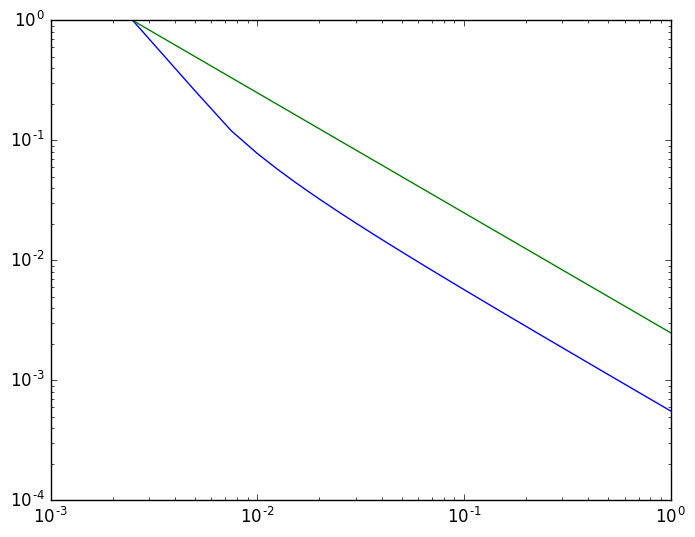

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32e44a950>

In [26]:
loglog(yy,pp_test)
loglog(yy,1./(N*yy))

# using JLD

## Testing Joint Degree Distribution

In [217]:
N = 1000
k_range = get_k_range(N)
G = graph_from_gamma_distribution(N,k,sigma_k,min_degree)

{1000, 6775} undirected graph

In [218]:
neighbor_degrees = [Float64[] for k in k_range]
n_trials = 50
for i in 1:n_trials
    G = graph_from_gamma_distribution(N,k,sigma_k,min_degree)
    for v in vertices(G)
        curr_degree = degree(G,v)
        for w in neighbors(G,v)
            push!(neighbor_degrees[curr_degree],degree(G,w))
        end
    end
end

all_neighbor_degrees = vcat(neighbor_degrees...)

650510-element Array{Float64,1}:
  23.0
  20.0
  23.0
   3.0
  71.0
  55.0
  32.0
  28.0
   8.0
  46.0
  14.0
   8.0
  64.0
   ⋮  
  68.0
  28.0
  19.0
  23.0
  20.0
   3.0
  44.0
  43.0
  26.0
  90.0
  55.0
 155.0

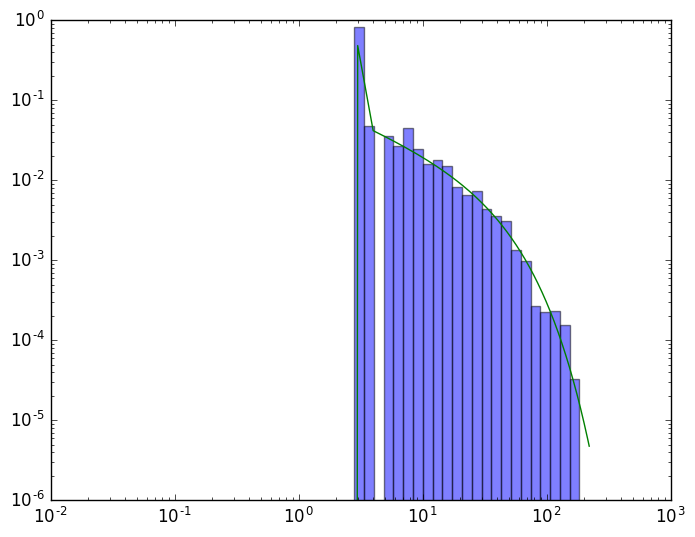

In [219]:
p_k_fn = get_p_k_gamma(sigma_k,k,3)
ks = degree(G)
bins = logspace(log10(minimum(ks))-2,log10(maximum(ks)),50)
PyPlot.plt[:hist](ks,bins=bins,normed=true,alpha=0.5,log=true);
k_range = 1:maximum(ks)
plot(k_range,[p_k_fn(_) for _ in k_range])
xscale("log")

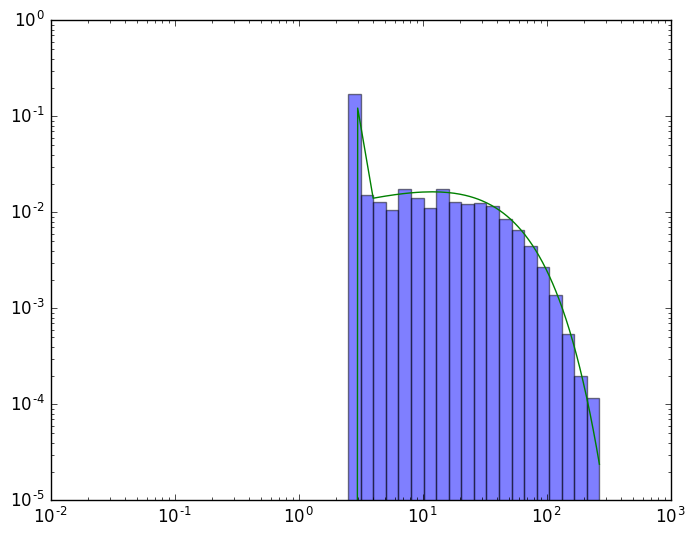

In [220]:
ks = all_neighbor_degrees
bins = logspace(log10(minimum(ks))-2,log10(maximum(ks)),40)
PyPlot.plt[:hist](ks,bins=bins,normed=true,alpha=0.5,log=true);
k_range = 1:maximum(ks)
plot(k_range,[neighbor_degree_distribution(_) for _ in k_range])
xscale("log")

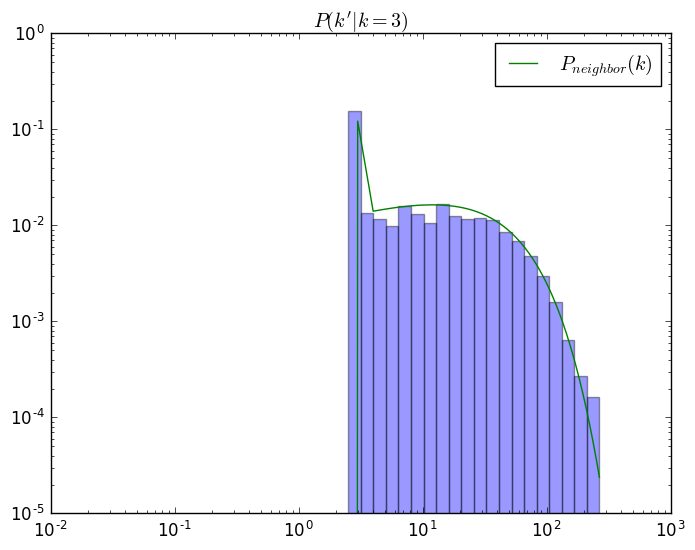

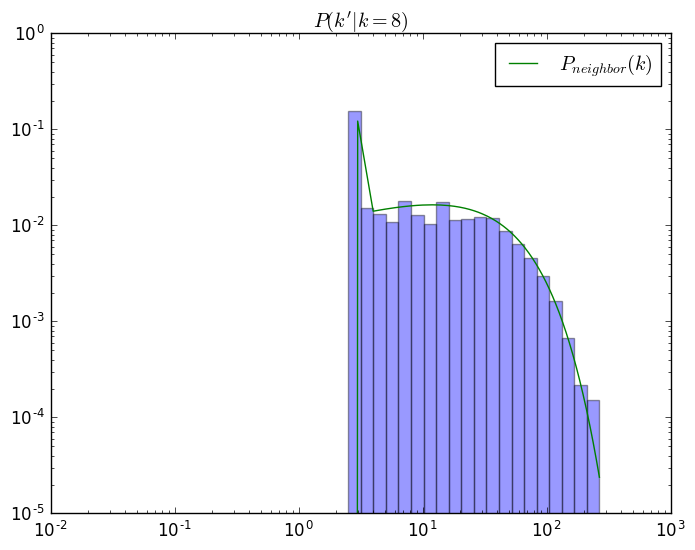

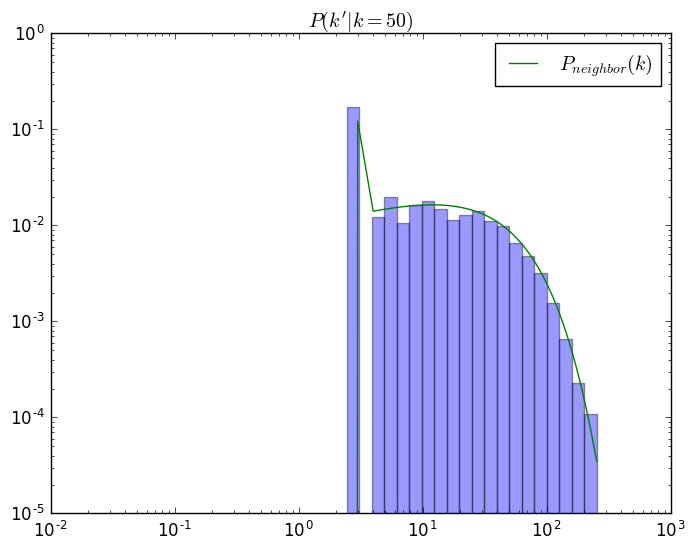

In [225]:

condition_degrees = [3,8,50]
for condition_degree in condition_degrees
    figure()
    title(latexstring("\$P(k'|k=$(condition_degree))\$"))
    ks = neighbor_degrees[condition_degree]
    bins = logspace(log10(minimum(ks))-2,log10(maximum(ks)),40)
    PyPlot.plt[:hist](ks,bins=bins,normed=true,alpha=0.4,log=true);
    k_range = 1:maximum(ks)
    plot(k_range,[neighbor_degree_distribution(_) for _ in k_range],label=L"P_{neighbor}(k)")
    xscale("log")
    legend(loc="best")
end


## Ideas

- The solutions for $y_k$ are expected: for lower degree, we expect higher infection rates.
- This clearly does not capture the behavior of the simulations
- Maybe we are missing the fact that each run starts with _a specific node of degree k_. Maybe we can have a theory conditioning on the starting node. Then we average over starters.
    - could test this as follows: take a graph with a bimodal degree distribution (to give k and sigma_k). Then start with 2/N nodes and place them on the two types of nodes (so we achieve approximately equal starting point density).

### How can any $s$ give rise to a non-neutral $P_{reach}$ for low $y$?

In [311]:
using JLD
data_dir_path = "../data/"  #"/mnt/D/windows/MIT/classes/6/338/project/data/"
filenames = split(readall(`ls $data_dir_path`));
path = data_dir_path*filenames[end-1]
d = JLD.load(path)
params = d["params"]
compact = params["compact"]
runs = d["runs"]
sizes = runs.sizes
pvals = runs.p_reach
yvals = runs.y_reach


interpolation_order = 3
pvals_fn(x) = evaluate(Spline1D(yvals,pvals,k=interpolation_order,bc="extrapolate"),x)

pvals_fn (generic function with 1 method)

In [320]:
yyy = collect(1/N:1/(10*N):1)
vec = (1./pvals_fn(yyy))
h = diff(yyy)[1]
up = vec[3:end]
mid = vec[2:end-1]
down = vec[1:end-2]

dpdy = (up - down)/(2*h)
d2pd2y = (up + down - 2*mid)/(h^2)
dpdy,d2pd2y

([5016.88,4348.0,3455.08,2784.68,2700.22,3040.07,3421.92,3713.0,3841.23,3741.96  …  4.60976e5,4.9268e5,5.27771e5,5.66751e5,610216.0,6.58883e5,7.13616e5,7.75467e5,8.45728e5,925996.0],[-4.5658e6,-8.81191e6,-9.04648e6,-4.36151e6,2.67234e6,4.12476e6,3.51226e6,2.30919e6,2.55461e5,-2.2409e6  …  3.01238e8,3.32828e8,3.68996e8,4.10601e8,4.58705e8,5.14629e8,5.80028e8,6.56999e8,7.48219e8,8.57145e8])

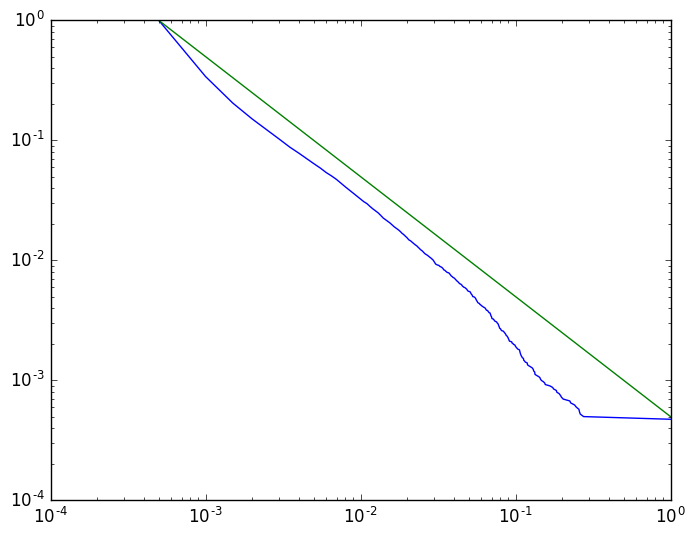

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3337135d0>

In [321]:
loglog(yvals,pvals_fn(yvals))
loglog(yvals,1./(2000*yvals))

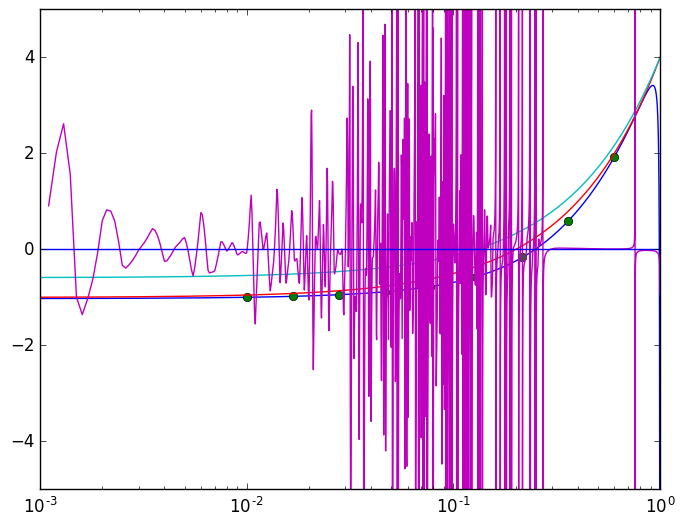

(-5,5)

In [322]:
semilogx(yy,s_fn(yy)./(yy.*(1 - yy)))
plot(y_desired_range,s./(y_desired_range.*(1 - y_desired_range)),"o")
plot(yy,alpha*yy - beta)
plot(yy,get_s_eff_exact(yy,alpha,beta,k,N))
plot(yyy[2:end-1],-1/N*d2pd2y./dpdy)
axhline(0)
ylim([-5,5])